##### Copyright 2023 The TensorFlow Authors.


In [27]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# Topic Modelling with `tfp` built-in Variational Inference Methods

This notebook presents TensorFlow Probability-VI application to LDA. Orientation: https://colab.research.google.com/github/tensorflow/probability/blob/main/tensorflow_probability/examples/jupyter_notebooks/Variational_Inference_and_Joint_Distributions.ipynb

---

# Latent Dirichlet Allocation - Sampling with Variational Inference (VI) Methods

_Notebook orignially contributed by: [Jannis Zeller](https://janniszeller.github.io/)_

This notebook shows how to implement inference for [Latent Dirichlet Allocation](https://www.jmlr.org/papers/volume3/blei03a/blei03a.pdf) (LDA, sometimes also called "topic model"), a generative probabilistic model by Blei, Ng & Jordan (2003), with TensorFlow Probability's (`tfp`) VI methods. For this presentation I use the popular toy model from [Griffiths & Steyvers (2004)](https://www.pnas.org/doi/full/10.1073/pnas.0307752101).

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/examples/blob/master/tensorflow_examples/probability/LDA-tfp-VI.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/examples/blob/master/tensorflow_examples/probability/LDA-tfp-VI.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
</table>

## Setup

In [28]:
import tensorflow_probability as tfp
import tensorflow as tf
tfd = tfp.distributions
tfb = tfp.bijectors
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(42)
tf.random.set_seed(42)

In [29]:
import src_lda.utils as tpc_utils
import src_lda.data  as tpc_data

---

## Data Generation

In this part the data is sampled. I have setup a sampler in one of the source files that transparently executes every step. This notebook shows how the procedure can be used with varying document lengths and with fixed document lengths.

In [30]:
N_docs       = 1000
sqrt_N_vocab = 3
N_words      = 100

## Variable Document Lengths?
uniform_doclengths = False
## Unconstraining Bijectors
use_softmax = True # Else softplus is used

N_topics = int(2*sqrt_N_vocab)
N_vocab  = int(sqrt_N_vocab**2)

Sampling a dataset with fixed document length or with varying document lengths

In [31]:
data = tpc_data.squareLDDocuments(
    N_docs=N_docs, 
    sqrt_N_vocab=sqrt_N_vocab, 
    N_words=N_words,
    uniform_doclengths=uniform_doclengths)

The choice of names for the tensors follows the Overview-section.

In [32]:
Theta, Pi, C_DId, C_DIdK, words = data.extract_params()

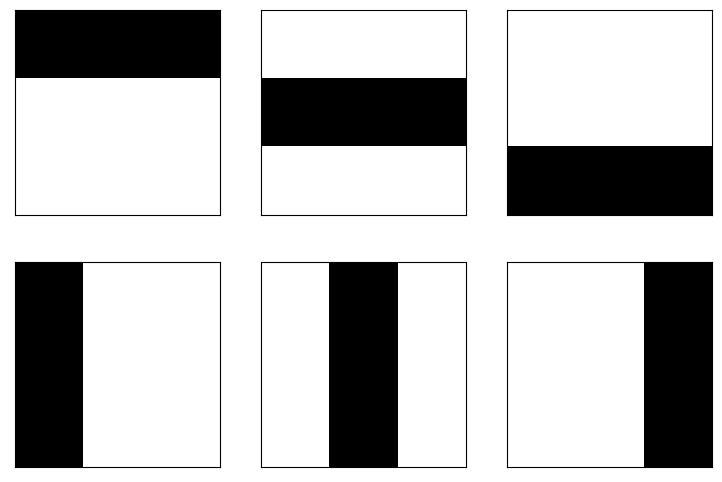

In [33]:
_ = tpc_utils.visualize_topics(Theta, N_row=2, N_col=3)

The goal is to reconstruct these topic-word prevalences using just the observed data, i. e. the `words`.

#### Preprocessing the Data

If the document length is variable, `tfp` methods are not directly applicable, because it lacks capabilities for processing `tf.RaggedTensor`s (as far as I can tell, 2023-01-31). Thus no (joint)-distribution can be defined which samples variable-length documents. The idea is, to pad each document to the size of the longest document base on the observed frequency of each token in the document in a catrgorical-distributed manner:

$$
    X_{\textsf{pad}}^{(j)} \overset{\textsf{iid}}{\sim} \textsf{Categorcial}\left( \frac{\textsf{count}(x_i)}{\textsf{len}(\textsf{doc}_j)}; \ i =1,\dots, V \right)
$$

This should work becaus topic models are bag-of-words models where only the (relative) frequency of token occurances matter. This approach will improve in performace the more word per document are used.

In [34]:
if not uniform_doclengths:
    pad_token = N_vocab + 1
    single_doclengths = words.nested_row_lengths()[0].numpy()
    N_words = tf.reduce_max(single_doclengths)

    words_ragged = words.to_tensor(N_vocab+1).numpy()
    words = []

    def pad_single_doc(doc, length, N_words_max=N_words):
        pad_size    = N_words_max - length
        doc_padded  = doc
        doc         = doc[doc != pad_token]
        idx, freq   = np.unique(doc, return_counts=True)
        freq        = freq / np.sum(freq)
        pad         = np.random.choice(idx, size=pad_size, p=freq)
        doc_padded[doc_padded == pad_token] = pad
        return doc_padded

    for doc, length in zip(words_ragged, single_doclengths):
        words.append(pad_single_doc(doc, length))
    
    words = tf.constant(words, dtype=tf.int32)

---

## Defining the Joint

Orientation was provided by https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability. Let $V$ be the size of the vocabulary, $D$ be the number of documents, $N$ be the (maximum) document size and $K$ be the number of topics. In this toy model which provides practical visualization capabilities we have $\sqrt{V} \in \mathbb N$ and $K=2 \cdot \sqrt{V} \in \mathbb N$.

The "$C$-step" can be "integrated out" using `tfp`'s `MixtureSameFamily`-distribution-class (see for gaussian mixture model in https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model).

In [35]:
## Priors:
alphas = tf.ones((N_docs, N_topics),  dtype=tf.float32)
betas  = tf.ones((N_topics, N_vocab), dtype=tf.float32)      
## Joint
joint = tfd.JointDistributionNamed(
    dict(
        Pi    = tfd.Dirichlet(alphas),
        Theta = tfd.Dirichlet(betas),
        W     = lambda Pi, Theta: tfd.Sample(  
            tfd.MixtureSameFamily(
                mixture_distribution=tfd.Categorical(probs=Pi),
                components_distribution=tfd.Categorical(probs=Theta)),
            sample_shape=N_words)),
    batch_ndims=0,
    use_vectorized_map=True)

Testing the joint:

In [36]:
## Sampling behavior 
sample = joint.sample()
for key, val in sample.items():
    print(f"Joint Sample Shape {key}: {val.shape}")
## Log-probability of observed (possibly padded data) assuming the joint
p = joint.log_prob(W=words, Pi=Pi, Theta=Theta).numpy()
p_sample = joint.log_prob(W=sample['W'], Pi=sample['Pi'], Theta=sample['Theta']).numpy()
print(f"Log-Probability of the observed data: {p}")
print(f"Log-Probability of the sample from the joint: {p_sample}")

Joint Sample Shape Theta: (6, 9)
Joint Sample Shape Pi: (1000, 6)
Joint Sample Shape W: (1000, 135)
Log-Probability of the observed data: -272105.625
Log-Probability of the sample from the joint: -282902.0


Presenting documents [182 422 738 428 603  37 333 933 543 468]


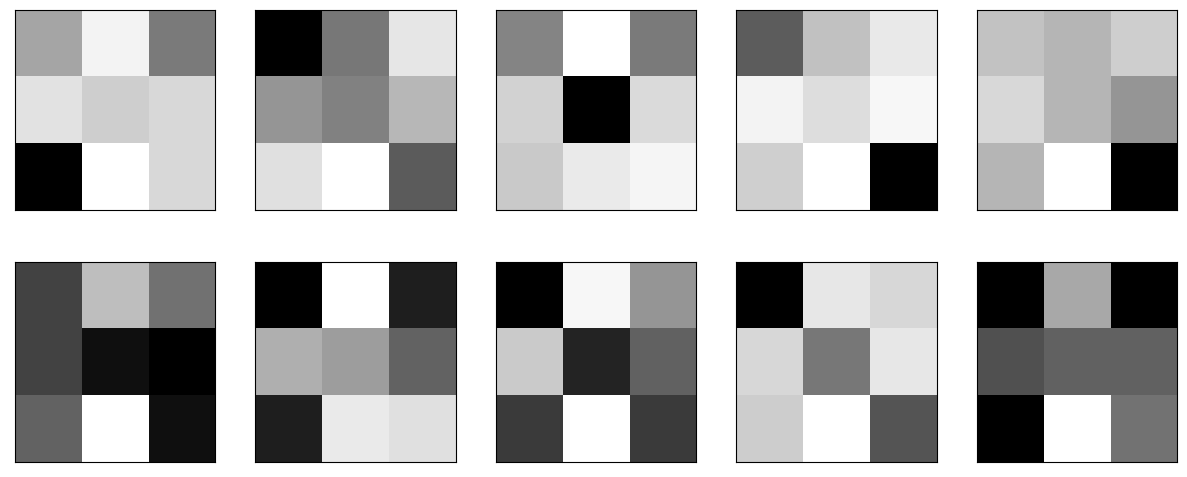

In [37]:
## Visualize documents from the prior-joint
_ = tpc_utils.visualize_random_docs(joint.sample()['W'], sqrt_V=sqrt_N_vocab)

### Defining the "Observed" Posterior:

In [38]:
def unnormalized_posterior(Pi, Theta):
    return joint.log_prob(W=words, Pi=Pi, Theta=Theta) # Incorporate data with "words"

---

### Defining & Fitting Surrogate Posterior

TensorFlow Probability provides an experimental utility [`tfp.experimental.vi.build_factored_surrogate_posterior`](https://www.tensorflow.org/probability/api_docs/python/tfp/experimental/vi/build_factored_surrogate_posterior) which by default assumes normal-distributed individual factors, that can be trainsformed to suitable domains and shapes using unconstraining bijectors. I found this method to be pretty robust and it yielded quite good results for this usecase.

In [39]:
## Constraints
if use_softmax:
    unconstraining_bijectors = {
        'Pi':    tfb.SoftmaxCentered(),
        'Theta': tfb.SoftmaxCentered()}

## Similar but with other bijectors
if not use_softmax:
    unconstraining_bijectors = {
        'Pi':    tfb.Softplus(),
        'Theta': tfb.Softplus()}

## Using tfp.experimental.vi.build_factored_surrogate_posterior
#  Event shapes (Omitting W)
event_shape = {key: joint.event_shape_tensor()[key] for key in ('Pi', 'Theta')}
surrogate_posterior = tfp.experimental.vi.build_factored_surrogate_posterior(
    event_shape=event_shape, 
    bijector=unconstraining_bijectors)

In [40]:
## Setting training loop parameters
learning_rate = 0.03
N_steps = 500
sample_size = 32

@tf.function
def run_fit(surrogate_posterior):
    losses = tfp.vi.fit_surrogate_posterior(
        unnormalized_posterior,
        surrogate_posterior=surrogate_posterior,
        num_steps=N_steps,
        optimizer=tf.optimizers.Adam(learning_rate),
        sample_size=sample_size)
    return losses

losses = run_fit(surrogate_posterior)

---

## Assessing Results 

Note that after the fit-process the surrogate posterior actually approximates the true posterior.

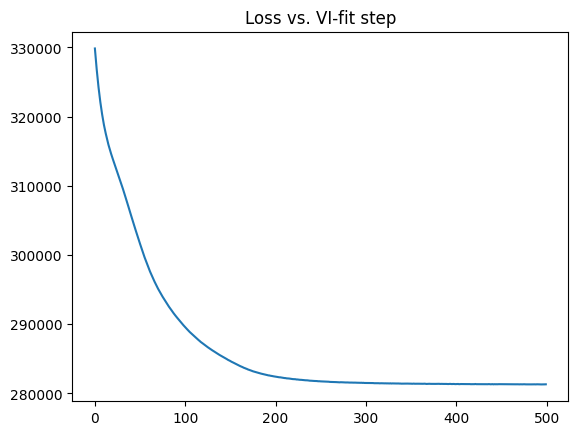

In [41]:
_ = sns.lineplot(
    x=np.arange(0, len(losses)), 
    y=losses).set(
    title="Loss vs. VI-fit step")

In [42]:
sample = surrogate_posterior.sample(1000)
Thetas_sample = sample['Theta']
if not use_softmax:
    Thetas_sample = tf.nn.softmax(Thetas_sample) # For normalization

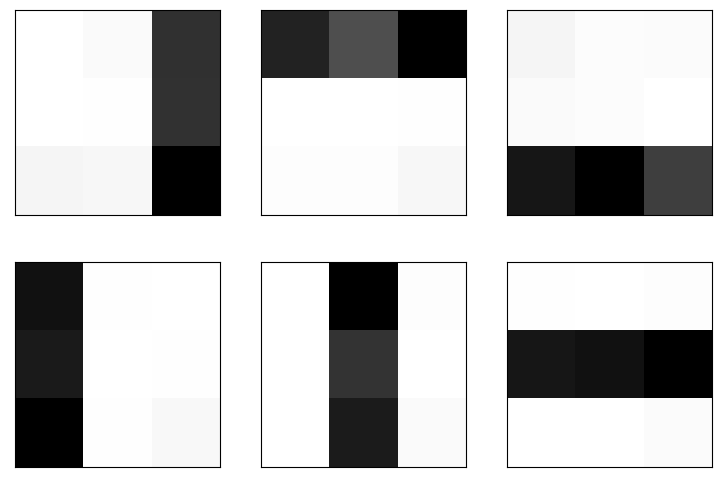

In [43]:
_ = tpc_utils.visualize_topics(tf.reduce_mean(Thetas_sample, axis=0), N_row=2, N_col=3)

Text(0.5, 1.0, '$\\Theta_{66}$ Sample Distribution')

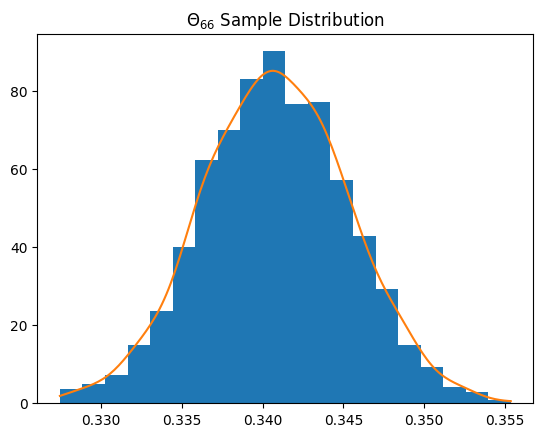

In [58]:
from scipy.stats import gaussian_kde, norm

theta_kv_sample = Thetas_sample[:, 5, 5].numpy()
density = gaussian_kde(theta_kv_sample)
xx = np.linspace(min(theta_kv_sample), max(theta_kv_sample), 200)

fig, ax = plt.subplots()
ax.hist(theta_kv_sample, bins=20, density=True, label="Histogram of sample")
ax.plot(xx, density(xx), label="KDE of sample")
ax.set_title("$\Theta_{66}$ Sample Distribution")

## Defining the Joint

Orientation was provided by https://www.tensorflow.org/probability/examples/A_Tour_of_TensorFlow_Probability. Let $V$ be the size of the vocabulary, $D$ be the number of documents, $N$ be the (maximum) document size and $K$ be the number of topics. In this toy model which provides practical visualization capabilities we have $\sqrt{V} \in \mathbb N$ and $K=2 \cdot \sqrt{V} \in \mathbb N$.

The "$C$-step" can be "integrated out" using `tfp`'s `MixtureSameFamily`-distribution-class (see for gaussian mixture model in https://www.tensorflow.org/probability/examples/Bayesian_Gaussian_Mixture_Model).